### Development of a score based on the gaussian heatmaps 
This can be used to generate the 'ground truth' score of the heatmaps produced from the Contextual layer , which will be compared with the score produced from the FCN heatmaps layer. 

- First we generate the heatmaps, and also visually cehck them. 
- the we pass the heatmaps to the routine that prodcues the scores 


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.utils       import mask_string
import mrcnn.visualize as visualize
from mrcnn.prep_notebook import prep_dev_notebook

model, dataset_train, train_generator, config = prep_dev_notebook(init_with = 'last', FCN_layers = False)

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.4 
 Initialize config object - super
(56, 56)
>>> Initialize model WITHOUT MASKING LAYERS!!!!
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_development_logs\shapes20180517T1245\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)

>>> Generate pyramid anchors 
      Anchor  scales:   (8, 16, 32, 64, 128)
      Anchor  ratios:   [0.5, 1, 2]
      Anchor  stride:   1
      Feature sh

     Prob_grid shape before tanspose:  (128, 128, ?)
     Prob_grid shape after tanspose:  (?, 128, 128)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, ?, 2)
    << output probabilities shape: (?, 128, 128)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 128, 128)
    gauss_scatt     :  (5, 4, 100, 128, 128)

    Reduce sum based on class ---------------------------------------------
    gaussian_sum shape     :  (5, 4, 128, 128) Keras tensor  False
    gaussian sum type/name :  <class 'tensorflow.python.framework.ops.Tensor'> cntxt_layer/gt_heatmap:0 gt_heatmap
    gaussian_sum shape     :  (5, 128, 128, 4) Keras tensor  False

    L2 normalization ------------------------------------------------------
    gauss-sum.shape: (5, 128, 128, 4) tf.shape : Tensor("cntxt_layer/Shape_9:0", shape=(4,), dtype=int32)
    gauss_flatten    :  (None, None, None) (?, ?, ?)  Keras tensor  False
   

In [2]:
train_batch_x, train_batch_y = next(train_generator)


>>> Generate pyramid anchors 
      Anchor  scales:   (8, 16, 32, 64, 128)
      Anchor  ratios:   [0.5, 1, 2]
      Anchor  stride:   1
      Feature shapes:   [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
      Feature strides:  [4, 8, 16, 32, 64]
>>> generate_anchors()
    scales:  8 ratios:  [0.5, 1, 2]
    meshgrid scales:  (3, 1) ratios:  (3, 1)
    flattened meshgrid scales and ratios:  (3,) (3,)
    Heights  [11.3137  8.      5.6569]  widths   [ 5.6569  8.     11.3137]
>>> generate_anchors()
    scales:  16 ratios:  [0.5, 1, 2]
    meshgrid scales:  (3, 1) ratios:  (3, 1)
    flattened meshgrid scales and ratios:  (3,) (3,)
    Heights  [22.6274 16.     11.3137]  widths   [11.3137 16.     22.6274]
>>> generate_anchors()
    scales:  32 ratios:  [0.5, 1, 2]
    meshgrid scales:  (3, 1) ratios:  (3, 1)
    flattened meshgrid scales and ratios:  (3,) (3,)
    Heights  [45.2548 32.     22.6274]  widths   [22.6274 32.     45.2548]
>>> generate_anchors()
    scales:  64 ratios:  [0.

Image id:  149
Image meta [149 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3]


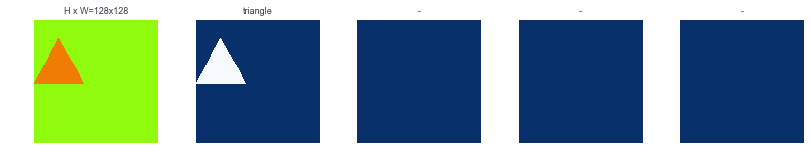

Image id:  19
Image meta [ 19 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 1 2 1]


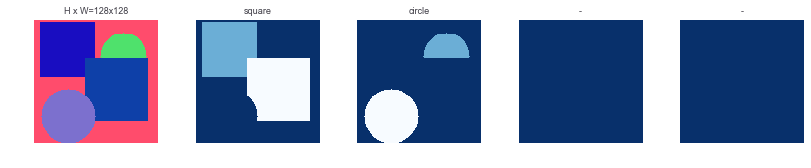

Image id:  23
Image meta [ 23 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 2 1]


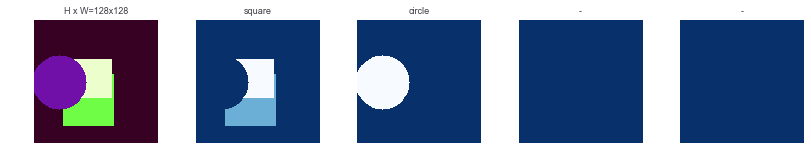

Image id:  139
Image meta [139 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 2 1]


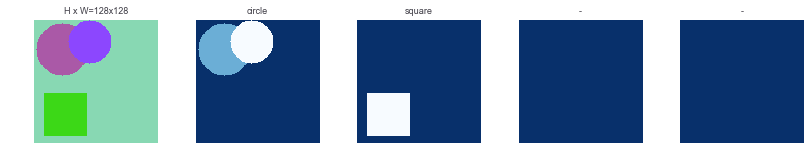

Image id:  116
Image meta [116 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 1 1]


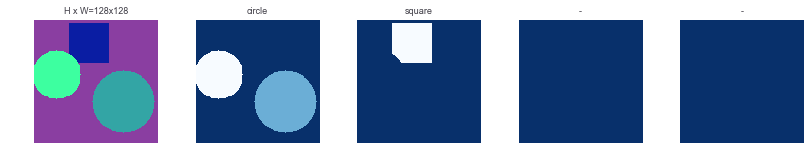

In [3]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [4]:
model.layer_info()
# model.keras_model.outputs[0].name



 Inputs:
 -------
 layer:  0    output : input_image:0                              Type: float32           Shape: (?, 128, 128, 3)
 layer:  1    output : input_image_meta:0                         Type: float32           Shape: (?, ?)
 layer:  2    output : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 layer:  3    output : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 layer:  4    output : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 layer:  5    output : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)
 layer:  6    output : input_gt_masks:0                           Type: bool              Shape: (?, 56, 56, ?)


 Outputs:
 --------
 layer:  0    output : rpn_class_logits/concat:0                  Type: float32           Shape: (?, ?, 2)
 layer:  1    output : rpn_class/concat:0                         Type: float32           Shape:

In [5]:
sess = KB.get_session()
print(sess)
print(sess.list_devices())

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, -2003976192)]


In [6]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(model.keras_model, train_batch_x, [1,2,3,4, 15,17,19], 1)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (5, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (5, 12)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (5, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (5, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (5, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (5, 100, 4)
Input  6:  (input_gt_masks:0                        ) 	  Input shape: (5, 56, 56, 100)

/* Outputs */
Output idx:  0    Layer:  1: (rpn_class/concat:0                      ) 	  Output shape: (5, 4092, 2)
Output idx:  1    Layer:  2: (rpn_bbox/concat:0                       ) 	  Output shape: (5, 4092, 4)
Output idx:  2    Layer:  3: (rpn_proposal_rois/packed_2:0            ) 	  Output shape: (5, 2000, 4)
Output idx:  3    Layer:  4: (proposal_targets/output_rois:0          ) 	  Output shape:

In [7]:
print(len(model_output))

rpn_class                 = model_output[0]          # layer:  1   shape: (5, 4092, 2)
rpn_bbox                  = model_output[1]          # layer:  2   shape: (5, 4092, 4)
rpn_proposal_rois         = model_output[2]          # layer:  3   shape: (5, 2000, 4)
output_rois               = model_output[3]          # layer:  4   shape: (5, 32, 4)
pred_heatmap_norm         = model_output[4]          # layer: 15   shape: (5, 128, 128, 4)
pred_heatmap_scores       = model_output[5]          # layer: 17   shape: (5, 4, 32, 8)
pred_tensor               = model_output[6]          # layer: 19   shape: (5, 4, 32, 6)
# print(type(model_output[4]))
# print(type(output_rois))
for i in model_output:
    print( i.shape)

7
(5, 4092, 2)
(5, 4092, 4)
(5, 2000, 4)
(5, 32, 4)
(5, 128, 128, 4)
(5, 4, 32, 9)
(5, 4, 32, 6)


In [8]:
input_image      =  train_batch_x[0]
input_image_meta =  train_batch_x[1]
input_rpn_match  =  train_batch_x[2]
input_rpn_bbox   =  train_batch_x[3]
input_gt_class_ids = train_batch_x[4]
input_gt_bboxes    = train_batch_x[5]
input_gt_masks     = train_batch_x[6]
print(' Input image shape is :', input_image.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
input_normlzd_gt_bboxes = tf.identity(input_gt_bboxes / [h,w,h,w])

# gt_masks   =  train_batch_x[6]
print(' input_rpn_match    ', input_rpn_match.shape)
print(' input_rpn_bbox     ', input_rpn_bbox.shape)
print(' input_gt_class_ids ', input_gt_class_ids.shape)
print(' input_gt_bboxes    ', input_gt_bboxes.shape)
print(' input_normlzd_gt_bboxes    ', input_normlzd_gt_bboxes.shape)


 Input image shape is : (5, 128, 128, 3)
 input_rpn_match     (5, 4092, 1)
 input_rpn_bbox      (5, 256, 4)
 input_gt_class_ids  (5, 100)
 input_gt_bboxes     (5, 100, 4)
 input_normlzd_gt_bboxes     (5, 100, 4)


In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=120, suppress=True)
img = 0

print(KB.int_shape(output_rois))
print(output_rois[img,:15]*[128, 128,128,128])
print(input_gt_class_ids[0])

print(' Pred_tensor')
print(pred_tensor.dtype)
print(pred_tensor[img,:,:10])

print(' Pred Heatmap Scores')
print(pred_heatmap_scores.dtype)
print(pred_heatmap_scores[img,:,:10])

### Repeat tesnor at given axis n times

In [36]:
import tensorflow as tf
import keras.layers as KL
np.set_printoptions(linewidth=130,precision=4,threshold=7000, suppress = True)

sess  = KB.get_session()
print(sess)
test1 = KB.identity(output_rois)
print(pred_heatmap_norm.shape)
pred_hm_norm = KB.identity(pred_heatmap_norm)
test1 = tf.transpose(pred_heatmap_norm, (0,3,1,2))
test1_shape = KB.int_shape(test1)

with sess.as_default():
    print(test1_shape)
    test1_sum = tf.reduce_sum(test1, [2,3]).eval()
    print('test1_sum is ', test1_sum.shape)
    for i in range(5):
        for j in range(4):
            print('img ',i,' class ', j, ' sum: ', test1_sum[i,j])
            
    test2 = tf.expand_dims(test1, axis =2)
    print('  Test2 shapes :',  test2.get_shape())
    test2 = tf.tile(test2, [1,2,32,1,1])
    print('  Test2 shapes :',  test2.get_shape())
    test2_sum = tf.reduce_sum(test2, [3,4]).eval()
    print('test2_sum is ', test2_sum.shape)
    for i in range(5):
        for j in range(4):
            for k in range(32):
                print('img ',i,' class ', j, 'copy ',k, ' sum:',test2_sum[i,j,k])

#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())

#     ones = tf.ones([7 ,1, 1, 1], dtype = tf.float32)    
#     test2 = test1 * ones
#     print(KB.int_shape(test2))

#     test2 = tf.tile(test2, [1,3,1,1])
#     for i in range(5):
#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())


# with sess.as_default():
#     print(KB.int_shape(pred_hm_norm))
#     test1_shape = KB.int_shape(test1)
#     print(test1_shape)
#     print(test1[0,:6].eval())
#     print(test1[1,:6].eval())
#     print(test1[2,:6].eval())
#     print(test1[3,:6].eval())    
#     print(test1[4,:6].eval())    
#     test2 = tf.expand_dims(test1, axis =1)
# #     print('  Test1 shapes :',  test1.get_shape())
# #     ones = tf.ones([7 ,1, 1, 1], dtype = tf.float32)    
# #     test2 = test1 * ones
#     print(KB.int_shape(test2))

#     test2 = tf.tile(test2, [1,3,1,1])
#     for i in range(5):
#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())

# #     test3 = KB.reshape(test2, (-1,test1_shape[0], test1_shape[1]))    
# #     print(KB.int_shape(test3))
# #     print(test3.eval())


(5, 128, 128, 4)
(5, 4, 128, 128)
test1_sum is  (5, 4)
img  0  class  0  sum:  40.209385
img  0  class  1  sum:  0.0
img  0  class  2  sum:  0.0
img  0  class  3  sum:  26.573668
img  1  class  0  sum:  58.36871
img  1  class  1  sum:  22.962961
img  1  class  2  sum:  34.2826
img  1  class  3  sum:  0.0
img  2  class  0  sum:  68.54552
img  2  class  1  sum:  23.429699
img  2  class  2  sum:  24.405384
img  2  class  3  sum:  0.0
img  3  class  0  sum:  56.0515
img  3  class  1  sum:  32.07468
img  3  class  2  sum:  22.775547
img  3  class  3  sum:  0.0
img  4  class  0  sum:  62.276886
img  4  class  1  sum:  40.126335
img  4  class  2  sum:  16.670958
img  4  class  3  sum:  0.0
  Test2 shapes : (5, 4, 1, 128, 128)
  Test2 shapes : (5, 8, 32, 128, 128)
test2_sum is  (5, 8, 32)
img  0  class  0 copy  0  sum: 40.209385
img  0  class  0 copy  1  sum: 40.209385
img  0  class  0 copy  2  sum: 40.209385
img  0  class  0 copy  3  sum: 40.209385
img  0  class  0 copy  4  sum: 40.209385
img

img  2  class  1 copy  26  sum: 23.429699
img  2  class  1 copy  27  sum: 23.429699
img  2  class  1 copy  28  sum: 23.429699
img  2  class  1 copy  29  sum: 23.429699
img  2  class  1 copy  30  sum: 23.429699
img  2  class  1 copy  31  sum: 23.429699
img  2  class  2 copy  0  sum: 24.405384
img  2  class  2 copy  1  sum: 24.405384
img  2  class  2 copy  2  sum: 24.405384
img  2  class  2 copy  3  sum: 24.405384
img  2  class  2 copy  4  sum: 24.405384
img  2  class  2 copy  5  sum: 24.405384
img  2  class  2 copy  6  sum: 24.405384
img  2  class  2 copy  7  sum: 24.405384
img  2  class  2 copy  8  sum: 24.405384
img  2  class  2 copy  9  sum: 24.405384
img  2  class  2 copy  10  sum: 24.405384
img  2  class  2 copy  11  sum: 24.405384
img  2  class  2 copy  12  sum: 24.405384
img  2  class  2 copy  13  sum: 24.405384
img  2  class  2 copy  14  sum: 24.405384
img  2  class  2 copy  15  sum: 24.405384
img  2  class  2 copy  16  sum: 24.405384
img  2  class  2 copy  17  sum: 24.405384
im

img  4  class  1 copy  20  sum: 40.126335
img  4  class  1 copy  21  sum: 40.126335
img  4  class  1 copy  22  sum: 40.126335
img  4  class  1 copy  23  sum: 40.126335
img  4  class  1 copy  24  sum: 40.126335
img  4  class  1 copy  25  sum: 40.126335
img  4  class  1 copy  26  sum: 40.126335
img  4  class  1 copy  27  sum: 40.126335
img  4  class  1 copy  28  sum: 40.126335
img  4  class  1 copy  29  sum: 40.126335
img  4  class  1 copy  30  sum: 40.126335
img  4  class  1 copy  31  sum: 40.126335
img  4  class  2 copy  0  sum: 16.670958
img  4  class  2 copy  1  sum: 16.670958
img  4  class  2 copy  2  sum: 16.670958
img  4  class  2 copy  3  sum: 16.670958
img  4  class  2 copy  4  sum: 16.670958
img  4  class  2 copy  5  sum: 16.670958
img  4  class  2 copy  6  sum: 16.670958
img  4  class  2 copy  7  sum: 16.670958
img  4  class  2 copy  8  sum: 16.670958
img  4  class  2 copy  9  sum: 16.670958
img  4  class  2 copy  10  sum: 16.670958
img  4  class  2 copy  11  sum: 16.670958
im

###  Generate L2 norm on heatmap score

In [ ]:
# del scr
# del scr_norm
with sess.as_default():
#     print(tf.shape(scr).eval())
    print(pred_heatmap_scores[img,0])
    scr = pred_heatmap_scores[...,6]/pred_heatmap_scores[...,7]
    scr = tf.where(tf.is_nan(scr),  tf.zeros_like(scr), scr)       
    scr_norm = tf.nn.l2_normalize(scr, axis = -1)
#     print('l2 normalzied - 2')
#     print(tf.shape(scr_norm).eval())    
#     print(scr_norm.eval())
    scr_norm = tf.expand_dims(scr_norm, axis = -1)
#     print(tf.shape(scr_norm).eval())
    print('tst')
    tst = tf.concat([pred_heatmap_scores, scr_norm], axis = -1)
    print(tst.shape)
    print(tst[0].eval())

## `build_heatmap()`

#### Prepare values to pass to build_heatmap

In [ ]:
img = 2
max_score = np.max(mrcnn_class, axis = -1)
max_class = np.argmax(mrcnn_class, axis = -1)
# print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
print('max class[',img,']\n',max_class[img])
print('max score[',img,']\n',max_score[img])
print('mrcnn class.shape ',mrcnn_class.shape)
print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 


####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 1
print('Image ', img , '/ Class 0 ------------')
print(output_rois[0])
print('Image ', img , '/ Class 1 ------------')
print(output_rois[1])
print('Image ', img , '/ Class 2 ------------')
print(output_rois[2])




####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [58]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
print('Image ', img , '/ Class 0 ------------')
print(pred_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(pred_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(pred_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(pred_tensor[img,3])


pred_tensor shape is  (5, 4, 32, 6)
Image  0 / Class 0 ------------
[[ 44.693245  38.366226  95.12722   89.23996    0.         1.      ]
 [ 70.47533   47.879322 117.72875   95.1346     0.         1.      ]
 [ 59.786015  54.972664 110.76001  104.71891    0.         1.      ]
 [ 40.080326  48.67288   84.11395   94.963806   0.         1.      ]
 [ 58.780228  50.966446  97.890015  92.41641    0.         1.      ]
 [ 42.442627  20.54057  112.530014 104.388214   0.         0.999999]
 [  0.         0.         0.         0.         0.         0.999998]
 [  0.         0.         0.         0.         0.         0.999998]
 [  0.         0.         0.         0.         0.         0.999998]
 [  0.         0.         0.         0.         0.         0.999998]
 [  0.         0.         0.         0.         0.         0.999998]
 [  0.         0.         0.         0.         0.         0.999998]
 [  0.         0.         0.         0.         0.         0.999998]
 [  0.         0.         0.       


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', gt_tensor.shape)
img = 0
print('Image ', img , '/ Class 0 ------------')
print(gt_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(gt_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(gt_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(gt_tensor[img,3])


## `development_build_heatmap` - Using Alternative , more efficient method to generate `gauss_sum`
    Develped a more efficient way of gneerating the heatmap without dynamic_parittioning and avoiding redundant tensor manipulation

In [53]:
##def development_build_gaussian_tf(in_tensor, config, names = None):
# in_tensor = KB.constant(pred_tensor)
# graph1 = tf.Graph()
# with graph1.as_default():
# try:
#     print(' Session to close ', sess)
#     sess.close()
#     print('session was deleted ')
# except:
#     print(' Session was not defined ', sess)
#     pass
sess = KB.get_session()
print(' New session obtained from Kras', sess)

with sess.as_default():
    in_tensor = tf.identity(pred_tensor)
    # in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')

    config = model.config
    names = ['Dev']
    # def build_heatmap(in_tensor, config, names = None):

    num_detections  = config.DETECTION_MAX_INSTANCES
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    print('\n ')
    print('  > NEW build_heatmap() for ', names )
    print('    orignal in_tensor shape : ', in_tensor.shape)       
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES
    rois_per_image  = (in_tensor.shape)[2] 
    # strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num of bboxes per class is : ', rois_per_image )

    #-----------------------------------------------------------------------------    
    ## Stack non_zero bboxes from in_tensor into pt2_dense 
    #-----------------------------------------------------------------------------
    # pt2_ind shape is [?, 3]. 
    #   pt2_ind[0] corresponds to image_index 
    #   pt2_ind[1] corresponds to class_index 
    #   pt2_ind[2] corresponds to roi row_index 
    # pt2_dense shape is [?, 6]
    #    pt2_dense[0] is image index
    #    pt2_dense[1:4]  roi cooridnaytes 
    #    pt2_dense[5]    is class id 
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]), axis=-1)
    print('    pt2_sum shape ',pt2_sum.shape)
    # print(pt2_sum[0].eval())
    pt2_ind = tf.where(pt2_sum > 0)

    ## replaced the two operations below with the one above - 15-05-2018
    # pt2_mask = tf.greater(pt2_sum , 0)
    # pt2_ind  = tf.where(pt2_mask)
    # print(' pt2_mask shape ', pt2_mask.get_shape())
    # print(pt2_mask.eval())
    # print('    pt2_ind shape ', pt2_ind.get_shape())
    # print(pt2_ind.eval())

    pt2_dense = tf.gather_nd( in_tensor, pt2_ind)
    print('    dense shape ',pt2_dense.get_shape())

    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(img_w, dtype=tf.int32)
    Y = tf.range(img_h, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([tf.shape(pt2_dense)[0] , 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    before transpse ', bef_pos.get_shape())
    pos_grid = tf.transpose(bef_pos,[1,2,0,3])
    print('    after transpose ', pos_grid.get_shape())    

    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = pt2_dense[:,3] - pt2_dense[:,1]      # x2 - x1
    height = pt2_dense[:,2] - pt2_dense[:,0]
    cx     = pt2_dense[:,1] + ( width  / 2.0)
    cy     = pt2_dense[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('     Prob_grid shape before tanspose: ',prob_grid.get_shape())
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    print('     Prob_grid shape after tanspose: ',prob_grid.get_shape())    
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())

    #--------------------------------------------------------------------------------
    ## IMPORTANT: kill distributions of NaN boxes (resulting from bboxes with height/width of zero
    ## which cause singular sigma cov matrices
    #--------------------------------------------------------------------------------
    prob_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)


    ## scatter out the probability distributions based on class --------------------------
    print('\n    Scatter out the probability distributions based on class --------------') 
    gauss_scatt   = tf.scatter_nd(pt2_ind, prob_grid, [batch_size, num_classes, rois_per_image, img_w, img_h])
    print('    pt2_ind shape   : ', pt2_ind.shape)  
    print('    prob_grid shape : ', prob_grid.shape)  
    print('    gauss_scatt     : ', gauss_scatt.shape)   # batch_sz , num_classes, num_rois, image_h, image_w
    
    ## heatmap: sum gauss_scattered based on class ---------------------------------------
    print('\n    Reduce sum based on class ---------------------------------------------')         
    gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_heatmap2')
    gauss_sum = tf.where(gauss_sum > 1e-12, gauss_sum, tf.zeros_like(gauss_sum))
    print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )      
    
    ##---------------------------------------------------------------------------------------------
    ## heatmap L2 normalization
    ## Normalization using the  `gauss_sum` (batchsize , num_classes, height, width) 
    ## 17-05-2018 (New method, replace dthe previous method that usedthe transposed gauss sum
    ##---------------------------------------------------------------------------------------------
    print('\n    L2 normalization ------------------------------------------------------')   
    heatmap_shape=KB.shape(gauss_sum)
    print('    gauss-sum.shape:', gauss_sum.shape, 'tf.shape :', tf.shape(gauss_sum))

    gauss_flatten = KB.reshape(gauss_sum, (heatmap_shape[0], heatmap_shape[1], -1 ) )  # reshape to image, class
    output_norm   = KB.l2_normalize(gauss_flatten, axis = -1)    
    gauss_norm    = KB.identity(KB.reshape(output_norm,  heatmap_shape ) , name = names[0]+'_norm')   

    print('    gauss_flatten    : ', tf.shape(gauss_flatten).eval(session=sess) , gauss_flatten.shape,' Keras tensor ', KB.is_keras_tensor(gauss_flatten) )
    print('    output of norm   : ', tf.shape(output_norm).eval(session=sess)   , output_norm.shape  ,' Keras tensor ', KB.is_keras_tensor(output_norm) )
    print('    gauss_norm final : ', tf.shape(gauss_norm).eval(session=sess)    , gauss_norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_norm) )    

 New session obtained from Kras <tensorflow.python.client.session.Session object at 0x00000270F7AFD710>

 
  > NEW build_heatmap() for  ['Dev']
    orignal in_tensor shape :  (5, 4, 32, 6)
    num of bboxes per class is :  32
    pt2_sum shape  (5, 4, 32)
    dense shape  (?, 6)
    X/Y shapes : (128, 128) (128, 128)
    Ones:     (?, 1, 1)
    ones_exp * X (?, 1, 1) * (128, 128) =  (?, 128, 128)
    ones_exp * Y (?, 1, 1) * (128, 128) =  (?, 128, 128)
    before transpse  (?, 128, 128, 2)
    after transpose  (128, 128, ?, 2)
     Prob_grid shape before tanspose:  (128, 128, ?)
     Prob_grid shape after tanspose:  (?, 128, 128)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, ?, 2)
    << output probabilities shape: (?, 128, 128)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 128, 128)
    gauss_scatt     :  (5, 4, 32, 128, 128)

    Reduce sum based on class -----------------------

### Normalization using the  `gauss_sum` (batchsize , num_classes, height, width) (New method) 

In [42]:
# with sess.as_default():
#     ## heatmap: L2 normalization  -----------------------------------------------------------------
#     print('\n    L2 normalization ------------------------------------------------------')   
#     heatmap_shape=KB.shape(gauss_sum)
#     print('    gauss-sum.shape:', gauss_sum.shape, 'tf.shape :', tf.shape(gauss_sum))

#     gauss_flatten = KB.reshape(gauss_sum, (heatmap_shape[0], heatmap_shape[1], -1 ) )  # reshape to image, class
#     output_norm   = KB.l2_normalize(gauss_flatten, axis = -1)    
#     gauss_norm    = KB.identity(KB.reshape(output_norm,  heatmap_shape ) , name = names[0]+'_norm')   

#     print('    gauss_flatten    : ', tf.shape(gauss_flatten).eval(session=sess) , gauss_flatten.shape,' Keras tensor ', KB.is_keras_tensor(gauss_flatten) )
#     print('    output of norm   : ', tf.shape(output_norm).eval(session=sess)   , output_norm.shape  ,' Keras tensor ', KB.is_keras_tensor(output_norm) )
#     print('    gauss_norm final : ', tf.shape(gauss_norm).eval(session=sess)    , gauss_norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_norm) )


    L2 normalization ------------------------------------------------------
    gauss-sum.shape: (5, 4, 128, 128) tf.shape : Tensor("Shape_22:0", shape=(4,), dtype=int32)
    gauss_flatten    :  [    5     4 16384] (?, ?, ?)  Keras tensor  False
    output of norm   :  [    5     4 16384] (?, ?, ?)  Keras tensor  False
    gauss_norm final :  [  5   4 128 128] (5, 4, 128, 128)  Keras tensor  False


### Normalization using the TRANSPOSED `gauss_sum` (batchsize, height, width , num_classes)   (OLD method) 

In [ ]:
### (old method) Normalization using the TRANSPOSED gauss_sum

# with sess.as_default():
#     ## heatmap: L2 normalization  -----------------------------------------------------------------
#     print('\n    L2 normalization ------------------------------------------------------')   
#     heatmap_shape=KB.shape(gauss_sum_tp)
#     print('    gauss-sum.shape:', gauss_sum_tp.shape, 'tf.shape :', tf.shape(gauss_sum_tp))

#     gauss_flatten_tp = KB.reshape(gauss_sum, (heatmap_shape[0], -1, heatmap_shape[-1]) )  # reshape to image, class
#     output_norm_tp   = KB.l2_normalize(gauss_flatten_tp, axis = 1)    
#     gauss_norm_tp    = KB.identity(KB.reshape(output_norm_tp,  heatmap_shape ) , name = names[0]+'_norm')   

#     print('    gauss_flatten    : ', tf.shape(gauss_flatten_tp).eval() , gauss_flatten_tp.shape,' Keras tensor ', KB.is_keras_tensor(gauss_flatten) )
#     print('    output of norm   : ', tf.shape(output_norm_tp).eval()   , output_norm_tp.shape  ,' Keras tensor ', KB.is_keras_tensor(output_norm) )
#     print('    gauss_norm final : ', tf.shape(gauss_norm_tp).eval()    , gauss_norm_tp.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_norm) )

### Old method - generating `gauss_heatmap_scores` using `gauss_scatter`

This will NOT work for generating scores in FCN, since we do not have the heatmaps per individual bounding box. 
We need to apply the boundingbox masks on the GAUSS_SUM

#### If we use this to generate scores, the scores will only reflect the heatmap produced for one object's bounding box. The overlapping of bounding boxes will not affect the generated scores. Therefore, the scores are invariant of possible overlapping. 
#### We could possibly use this if we want to generate independent scores for bounding boxes with no overlaps. However it's important to consider the ramifications. 

In [13]:
with sess.as_default():
    ##--------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bouding box masks 
    ## NOTE: Score is generated on NON-NORMALIZED gaussian distributions
    ##       If want to do this on normalized, we need to apply normalization to gauss_scatt first
    ##--------------------------------------------------------------------------------------------
    # flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    in_tensor_flattened  = tf.reshape(in_tensor, [-1,6])
    bboxes = tf.to_int32(tf.round(in_tensor_flattened[...,0:4]))
    print('    in_tensor               ', in_tensor.shape)
    print('    in_tensorr_flattened is ', in_tensor_flattened.shape)
    print('    boxes shape          ', bboxes.shape)

    # DONT NEED THIS - was put there to try to avoid computing sum/area for zero bboxes.
    # kept as reference for future generations .....
    # bbox_sum = tf.reduce_max(in_tensor[...,0:3], axis = -1, name  = 'bbox_sum')
    # print(' bbox sum shape: ', bbox_sum.shape)

    gauss_scatt_shape   = KB.int_shape(gauss_scatt)
    gauss_scatt_reshape = KB.reshape(gauss_scatt, (-1, gauss_scatt_shape[-2], gauss_scatt_shape[-1]))
    print('    gaussian scatter shape : ', gauss_scatt_shape)
    print('    gaussian scatter reshaped : ', gauss_scatt_reshape.shape)
    print('    gaussian sum shape          ', KB.int_shape(gauss_sum))

    # ones_map = tf.ones([384,128,128])   
    scores = tf.map_fn(build_mask_routine, [gauss_scatt_reshape, bboxes], dtype=tf.float32)

    new_shape = tf.shape(in_tensor)+ [0,0,0,tf.shape(scores)[-1]]        
    gaussian_bbox_scores = tf.concat([in_tensor_flattened, scores], axis = -1)
    print('    in_tensor_flattened shape : ', scatter_flattened.shape)
    print('    Scores shape              : ', scores.shape)
    print('    gaussian_boxes_scores     : ', gaussian_bbox_scores.shape)    
    gaussian_bbox_scores = tf.reshape(gaussian_bbox_scores, new_shape, name = names[0]+'_scores')

    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
#     scr = gaussian_bbox_scores[...,-2]/gaussian_bbox_scores[...,-1]
#     scr = tf.where(tf.is_nan(scr),  tf.zeros_like(scr), scr)       
#     scr_norm = tf.nn.l2_normalize(scr, axis = -1)
#     scr_norm = tf.expand_dims(scr_norm, axis = -1)
#     gaussian_bbox_scores = tf.concat([gaussian_bbox_scores, scr_norm], axis = -1)

#     print('    gaussian_bbox_scores final shape   : ', gaussian_bbox_scores.shape)
#     print('    complete')

# return  gauss_norm, gaussian_bbox_scores    # [gauss_sum, gauss_scatt, means, covar]

    in_tensor                (5, 4, 32, 6)
    in_tensorr_flattened is  (640, 6)
    boxes shape           (640, 4)
    gaussian scatter shape :  (5, 4, 32, 128, 128)
    gaussian scatter reshaped :  (640, 128, 128)
    gaussian sum shape           (5, 4, 128, 128)


### NEW method - generating `gauss_heatmap_scores` using `gauss_sum`

Since FCN provides a heatmap per class , and not per individual object, we use the similar method here to generate heat maps. 

In [55]:
with sess.as_default():
    ##--------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bouding box masks 
    ## NOTE: Score is generated on NON-NORMALIZED gaussian distributions
    ##       If want to do this on normalized, we need to apply normalization to gauss_scatt first
    ##--------------------------------------------------------------------------------------------
    # flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    in_tensor_flattened  = tf.reshape(in_tensor, [-1,6])
    bboxes = tf.to_int32(tf.round(in_tensor_flattened[...,0:4]))
    print('    in_tensor               ', in_tensor.shape)
    print('    in_tensorr_flattened is ', in_tensor_flattened.shape)
    print('    boxes shape          ', bboxes.shape)

    print(rois_per_image)
    ##--------------------------------------------------------------------------------------------
    # duplicate gauss_sum <num_roi> times to pass along with bboxes to map_fn function
    ##--------------------------------------------------------------------------------------------
    temp = tf.expand_dims(gauss_sum, axis =2)
    print('  Gauss_Sum expanced shape :',  temp.get_shape())
    temp = tf.tile(temp, [1,1, rois_per_image ,1,1])
    print('  Gauss_Sum expanded/tiled shape :',  temp.get_shape())
    temp_shape   = KB.int_shape(temp)
    temp_reshape = KB.reshape(temp, (-1, temp_shape[-2], temp_shape[-1]))
    print('    gauss_sum original shape  : ', gauss_sum.shape)
    print('    gauss_sum replicated      : ', temp_shape)
    print('    gaussian scatter reshaped : ', temp_reshape.shape)

    scores = tf.map_fn(build_mask_routine, [temp_reshape, bboxes], dtype=tf.float32)
    # consider the two new columns for reshaping the gaussian_bbox_scores
    new_shape = tf.shape(in_tensor)+ [0,0,0, tf.shape(scores)[-1]]        
    gaussian_bbox_scores = tf.concat([scatter_flattened, scores], axis = -1)
    print('    Scatter Flattened shape : ', scatter_flattened.shape)
    print('    Scores shape :            ', scores.shape)
    print('    gaussian_boxes_scores initial shape: ', gaussian_bbox_scores.shape)    
    gaussian_bbox_scores = tf.reshape(gaussian_bbox_scores, new_shape, name = names[0]+'_scores')


    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
    scr = gaussian_bbox_scores[...,-2]/gaussian_bbox_scores[...,-1]
    scr = tf.where(tf.is_nan(scr),  tf.zeros_like(scr), scr)       
    scr_norm = tf.nn.l2_normalize(scr, axis = -1)
    scr_norm = tf.expand_dims(scr_norm, axis = -1)
    gaussian_bbox_scores = tf.concat([gaussian_bbox_scores, scr_norm], axis = -1)
    gauss_norm = tf.transpose(gauss_norm,[0,2,3,1], name = names[0])  
    
    
    print('    gauss_norm           final shape   : ', gauss_norm.shape)
    print('    gaussian_bbox_scores final shape   : ', tf.shape(gaussian_bbox_scores).eval())
    print('    complete')

# return  gauss_norm, gaussian_bbox_scores    # [gauss_sum, gauss_scatt, means, covar]

    in_tensor                (5, 4, 32, 6)
    in_tensorr_flattened is  (640, 6)
    boxes shape           (640, 4)
32
  Gauss_Sum expanced shape : (5, 4, 1, 128, 128)
  Gauss_Sum expanded/tiled shape : (5, 4, 32, 128, 128)
    gauss_sum original shape  :  (5, 4, 128, 128)
    gauss_sum replicated      :  (5, 4, 32, 128, 128)
    gaussian scatter reshaped :  (640, 128, 128)
    Scatter Flattened shape :  (640, 6)
    Scores shape :             (640, 2)
    gaussian_boxes_scores initial shape:  (640, 8)
    gauss_norm           final shape   :  (5, 128, 128, 4)
    gaussian_bbox_scores final shape   :  [ 5  4 32  9]
    complete


In [57]:
with sess.as_default():
    print(pred_heatmap_scores)

[[[[   44.6932    38.3662    95.1272    89.24       0.         1.         1.      2550.         0.3235]
   [   70.4753    47.8793   117.7288    95.1346     0.         1.         1.      2256.         0.3657]
   [   59.786     54.9727   110.76     104.7189     0.         1.         1.      2550.         0.3235]
   [   40.0803    48.6729    84.114     94.9638     0.         1.         1.      2024.         0.4076]
   [   58.7802    50.9664    97.89      92.4164     0.         1.         1.      1599.         0.5159]
   [   42.4426    20.5406   112.53     104.3882     0.         1.         1.      5893.         0.14  ]
   [    0.         0.         0.         0.         0.         1.         0.         0.         0.    ]
   [    0.         0.         0.         0.         0.         1.         0.         0.         0.    ]
   [    0.         0.         0.         0.         0.         1.         0.         0.         0.    ]
   [    0.         0.         0.         0.         0.         1

###  `build_mask` routine 

In [46]:
def build_mask_routine(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
    heatmap_tensor, input_row = input_list
    with tf.variable_scope('mask_routine'):
        y_extent     = tf.range(input_row[0], input_row[2])
        x_extent     = tf.range(input_row[1], input_row[3])
        Y,X          = tf.meshgrid(y_extent, x_extent)
        bbox_mask    = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        mask_applied = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        bbox_area    = tf.to_float((input_row[2]-input_row[0]) * (input_row[3]-input_row[1]))
        gaussian_sum = tf.reduce_sum(mask_applied)
    return tf.stack([gaussian_sum, bbox_area], axis = -1)

    

###  Compare results from old and new method of generating `gauss_sum`

In [ ]:
# try:
#     sess.close()
#     print('session was deleted ')
# except:
#     print('Session was not defined ')
#     pass
# sess = tf.InteractiveSession()
with sess.as_default():
    np.set_printoptions(linewidth=130, threshold=20000)
    gt   = gauss_norm_tp2 # gt_gaussian 
    gt2  = gauss_norm_tp # gt_gaussian_2
    # gt   = np.where(gt > 1e-6,gt,0)
    # gt2   = np.where(gt2 > 1e-6,gt2,0)
    print( ' pt shape ', gt.shape, ' pt2.shape ', gt2.shape)

    for img in range(3):
        print('Image', img)

        for cls in range(4):

            all_equal = np.all(np.equal(gt2[img, :,:,cls], gt[img, :,:,cls]))
        #         for roi in range(32):
    #             print('roi:', roi)
    #             equal = tf.equal(gt2[img, cls, roi, line], gt[img, cls,roi, line])
    #             all_equal = tf.reduce_all(equal).eval()     
            if all_equal:
                max_diff = np.max(gt2[img, :,:, cls]- gt[img, :,:,cls]).eval()
                print('Img: ', img, ' Cls',cls, 'All equal', all_equal, '    Largest diffeence in cls', cls,':', max_diff)            
            else:
                for line in range(128):
                    all_equal = np.all(np.equal(gt2[img, line,:,cls], gt[img, line,:,cls]))
                    if all_equal:
                        print('Img: ', img, 'Calss',cls, 'LINE', line, 'All equal', all_equal)   
                    else:
                        max_diff = np.max(gt2[img, line,:, cls]- gt[img, line,:,cls])
                        print('Img: ', img, 'Calss',cls, 'LINE', line, 'All equal', all_equal,' Max difference :', max_diff.eval() )
    #                 print(' -- pred_hm\n',  gt[img, line, :,cls])
    #                 print(' -- prd_hm2\n', gt2[img, line, :, cls])                


In [ ]:
feed_dict = {in_tensor: pred_tensor}
fetches = [stacked_tensor, rnd_tensor, gauss_sum]
sess = tf.Session()
print(' tfsession() is ', sess)
tt = sess.run(fetches, feed_dict = feed_dict )
print(type(tt), len(tt))
sess.close()

In [ ]:
img = 1
print(' Stacked Tensor Shape: ', tt[0].shape)
print(' Stacked Tensor :   \n ', tt[0][img])

print(' rnd_tensor shape ', tt[1].shape)
print(' rnd_tensor :  \n ', tt[1][img])

print(' Gauss_Sum shape :\n', tt[2].shape)
# print(' FP gt boxes        :\n', tt[3])
# print(' FP gt class assign :\n', tt[4])
# print(' gt class ids assign :\n', tt[5])
# print()
# print('fp_rois ', tt[6].shape, '\n',tt[6])
# print('rois ', tt[9].shape, '\n',tt[9])
# print()
# print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
# print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
# print()
# print('fp_rois_gt_class_ids ', tt[8].shape, '\n',tt[8])
# print('rois_gt_class_ids ', tt[11].shape, '\n',tt[11])
# # return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [ ]:
with sess.as_default():
    gauss_sum = development_build_gaussian_tf(KB.constant(pred_tensor), model.config, names = ['Dev'])

In [ ]:
    rnd_tensor = tf.floor(stacked_tensor)    
    sum_tensor = tf.reduce_sum(tf.abs(rnd_tensor[:,:,:4]), axis=-1)
    non_zero   = tf.cast(sum_tensor, tf.bool)
    non_zero_exp = tf.expand_dims(non_zero, axis =-1)
    
    print(' rnd_tensor :', tf.shape(rnd_tensor).eval())
    print(' sum_tensor :', tf.shape(sum_tensor).eval())
    print(' non_zero   :', tf.shape(non_zero).eval())
    print(' non_zero_exp:', tf.shape(non_zero_exp).eval())
    non_zero_exp = KB.repeat_elements(non_zero_exp, 6, axis=-1)
    print(' non_zero_exp:', tf.shape(non_zero_exp).eval())
    nz_tensor  = tf.boolean_mask(rnd_tensor, non_zero_exp, axis = -1)
    print(' nz_tensor  :', tf.shape(nz_tensor).eval())

#     print(stacked_tensor[0].eval())
    print(rnd_tensor[0].eval())
    print()
#     print(stacked_tensor[1].eval())
    print(rnd_tensor[1].eval())
    print()
#     print(stacked_tensor[2].eval())
    print(rnd_tensor[2].eval())
    
    print(sum_tensor[1].eval())    
    print(non_zero[1].eval())    
#     non_zeros = tf.cast(tf.reduce_sum(tf.abs(rnd_tensor), axis=1), tf.bool)
    print(non_zero_exp[1].eval())    

    print(nz_tensor[1].eval())
    print()


### Plot Predicted  Heatmaps `pred_gaussian` 

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
INPUT1 = pred_hm
INPUT2 = pred_hm_norm
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
# gt_heatmap  = layers_out[19]     # gt_gaussiam 
# pred_heatmap= layers_out[18]  # pred_gaussian
print('INPUT1 shape : ', INPUT1.shape, ' INPUT2 shape: ', INPUT2.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'INPUT1 -  image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', INPUT1[img,:,:,cls].shape, ttl)   
    plot_gaussian(INPUT1[img,:,:,cls], title = ttl)  
    
    ttl = 'INPUT2 -  image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', INPUT2[img,:,:,cls].shape, ttl)   
    plot_gaussian(INPUT2[img,:,:,cls], title = ttl)  

In [ ]:
print(pred_tensor[0,2])
print(output_rois[0,:])
width  = pred_tensor[:,:,:,3] - pred_tensor[:,:,:,1]      # x2 - x1
height = pred_tensor[:,:,:,2] - pred_tensor[:,:,:,0]
cx     = pred_tensor[:,:,:,1] + ( width  / 2.0)
cy     = pred_tensor[:,:,:,0] + ( height / 2.0)
means  = np.floor(np.stack((cy,cx),axis = -1))

print(means.shape)
print(means[0,2,:12])

In [ ]:
print(gt_tensor[0,2])
print(output_rois[0,:])
width  = gt_tensor[:,:,:,3] - gt_tensor[:,:,:,1]      # x2 - x1
height = gt_tensor[:,:,:,2] - gt_tensor[:,:,:,0]
cx     = gt_tensor[:,:,:,1] + ( width  / 2.0)
cy     = gt_tensor[:,:,:,0] + ( height / 2.0)
gt_means  = np.floor(np.stack((cy,cx),axis = -1))

print(gt_means.shape)
print(gt_means[0,2,:12])

###  Find maximum of gaussian distributions for the pred_heatmap
Potentially use this as our heatmap scores 
Found out that using MAX values from the class heatmap (currently generated from the pred_tensor that itself is generated form output_rois and mrcnn_class) is not a viable option, because mutlple max values tend to congreagate around the peak of the gaussian distribution. 
This is also the case for gt_heatmaps.
This will probably also be the case for the FCN output.

#### pred_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)

print(pred_hm.shape)
cls_hm = pred_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print(pred_hm_norm.shape)
cls_hm_norm = pred_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))


In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


#### gt_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
print(pred_hm.shape)
cls_hm = gt_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print('---- norm -----')
print(gt_hm_norm.shape)
cls_hm_norm = gt_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))



In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


In [ ]:
max_a = np.max(cls_pred_heatmap)
print(max_a.shape)

print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(means.get_shape(), means.get_shape())
tst1 = means.eval()
tst2 = means2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = st.eval()
tst2 = st2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = gauss_grid.eval()
tst2 = gauss_grid2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,0,:10])
print()
print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
tst1 = gauss_sum.eval()
tst2 = gauss_sum2.eval()
print(tst1.shape, tst2.shape)

# print(tst1[0,0,:10])
# print()
# print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

###  Compute mean and max of `gauss_grid()`

In [ ]:
print(gauss_grid.shape)
for img in [0,1,2]:
    for bbx in range(32):
        gauss_mean = KB.mean(gauss_grid[img, bbx,:,:]).eval()
        gauss_min  = KB.min(gauss_grid[img, bbx,:,:]).eval()
        gauss_max  = KB.max(gauss_grid[img, bbx,:,:]).eval()
#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     Mean:  {:6e}  \t Max: {:6e}  \t Min : {:6e}'.format(img, bbx, gauss_mean, gauss_max, gauss_min))

###  Compute mean and max of `gauss_grid2()`

In [ ]:
print(gauss_grid2.shape)
for img in [0,1,2]:
    for bbx in range(32):
        gauss_mean = KB.mean(gauss_grid2[img, bbx,:,:]).eval()
        gauss_min  = KB.min(gauss_grid2[img, bbx,:,:]).eval()
        gauss_max  = KB.max(gauss_grid2[img, bbx,:,:]).eval()
#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     Mean:  {:6e}  \t Max: {:6e}  \t Min : {:6e}'.format(img, bbx, gauss_mean, gauss_max, gauss_min))

###  Compute `gauss_grid()` and   `gauss_grid2()`

In [ ]:
print(gauss_grid2.shape)
gauss_max  = KB.max(gauss_grid, axis = [2,3]).eval()
gauss_max2  = KB.max(gauss_grid2, axis = [2,3]).eval()

for img in [0,1,2]:
    for bbx in range(32):

#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     MAX:  {:6e}  \t MAX2: {:6e}  \t Equal : {}'.format(img, bbx, gauss_max[img, bbx],gauss_max2[img,bbx],(gauss_max[img,bbx]== gauss_max2[img,bbx])))
del gauss_max, gauss_max2    

### Compute `gauss_sum()` and  `gauss_sum2()`

In [ ]:
print(gauss_sum.shape, gauss_sum2.shape)
# print(gauss_grid2.shape)
tst1 = tf.transpose(gauss_sum, [0,3,1,2])
tst2 = tf.transpose(gauss_sum2, [0,3,1,2])
print(tst1.shape, tst2.shape)

gauss_max1 = KB.max(tst1, axis = [2,3]).eval()
gauss_max2 = KB.max(tst2, axis = [2,3]).eval()
print(gauss_max1.shape, gauss_max2.shape)

# gauss_max2  = KB.max(gauss_grid2, axis = [2,3]).eval()

for img in [0,1,2]:
    for bbx in range(4):
        print('Img/bbx: {}/{}     MAX:  {:6e}  \t MAX2: {:6e}  \t Equal : {}'.format(img, bbx, gauss_max1[img, bbx],gauss_max2[img,bbx],(gauss_max1[img,bbx]== gauss_max2[img,bbx])))
   

In [ ]:
for img in [0,1,2]:
    for bbx in range(4):
        print('Img/bbx: {}/{}    Equal : {}'.format(img, bbx, (tst1[img,bbx]==  tst2[img,bbx])))
del gauss_max1, gauss_max2    


###  Compute mean and max OF `gauss_sum2()`

In [ ]:
print(gauss_sum2.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(gauss_sum2[img,:,:,cls]).eval()
        gauss_min  = KB.min(gauss_sum2[img, :,:,cls]).eval()
        gauss_max  = KB.max(gauss_sum2[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

### Compute min and max of `gauss_sum()`

In [ ]:
print(gauss_sum.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(gauss_sum[img,:,:,cls]).eval()
        gauss_min  =  KB.min(gauss_sum[img, :,:,cls]).eval()
        gauss_max  =  KB.max(gauss_sum[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

In [ ]:
pred_gauss = tf.constant(layers_out[19])
print(pred_gauss.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(pred_gauss[img,:,:,cls]).eval()
        gauss_min  = KB.min(pred_gauss[img, :,:,cls]).eval()
        gauss_max  = KB.max(pred_gauss[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

### Plot Predicted  Heatmaps `pred_gaussian` 

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
# gt_heatmap  = gauss_sum.eval()    # gt_gaussiam 
gt_heatmap  = layers_out[18]     # gt_gaussiam 

pred_heatmap= gauss_sum2.eval()  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  

### Plot Predicted  Heatmaps `pred_gaussian` 

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
gt_heatmap  = layers_out[19]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  


### Plot Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian` (Tensorflow)

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
gt_heatmap  = layers_out[19]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  

###  Softmax Sparse Cross Entropy Ignoring Last Label -- Used in Keras FCN

In [ ]:
import keras.backend as K 

y_pred = tf.placeholder(dtype=tf.float32, shape=(16,320,320,20))
y_true = tf.placeholder(dtype=tf.float32, shape=(16,320,320,1))
print(K.int_shape(y_pred), K.int_shape(y_true))
y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
print(K.int_shape(y_pred))
log_softmax = tf.nn.log_softmax(y_pred)
print(K.int_shape(log_softmax))

y_true = K.flatten(y_true)
print(K.int_shape(y_true))

y_true = K.one_hot(tf.to_int32(y_true), K.int_shape(y_pred)[-1]+1)
print(K.int_shape(y_true))

unpacked = tf.unstack(y_true, axis=-1)
print(len(unpacked), unpacked[0].shape)

y_true = tf.stack(unpacked[:-1], axis=-1)
print(K.int_shape(y_true))


cross_entropy = -K.sum(y_true * log_softmax, axis=1)
print(K.int_shape(cross_entropy))

cross_entropy_mean = K.mean(cross_entropy)
print(K.int_shape(cross_entropy_mean))




# import keras.backend as K
# print(K.int_shape(bef_pos)[-1])
# unpacked  = K.flatten(test)
# unpacked.shape

### Experimental code to Create mask for class bounding boxes


###  Comparing Scipy / Tensorflow Multivar normal distribution 

In [ ]:
tfd        = tf.contrib.distributions
grid       = pos_grid_1[:,:,0,0,:]
covar      = np.array([27.7818, 26.6678],dtype = np.float32)
covar_sqrt = np.sqrt(covar)
covar_sqrd = covar ** 2
full_covar = np.array([[27.7818, 0],[0, 26.6678]],dtype = np.float32)
mean       = np.array([48.8926, 36.101 ],dtype = np.float32)

print('   grid :', grid.dtype, grid.shape)
print('   Covar sqrt :', covar_sqrt)
print('   Covar sqrd :', covar_sqrd)

mvn1  = tfd.MultivariateNormalDiag(loc=mean,scale_diag=covar_sqrt)
prob1 = mvn1.prob(grid2)
print()
print('   mvn1 mean             ', mvn1.mean().eval())
print('   mvn1 std deviation    ', mvn1.stddev().eval())
print('   mvn1 covariance:      ', '\n', mvn1.covariance().eval())
print('   mvn1 location         ', mvn1.loc.eval())
print('   Linear OP shape       ', mvn1.scale.shape)
print('   Linear Op batch shape ', mvn1.scale.batch_shape)
print('   Linear op Range Dim   ', mvn1.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn1.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn1.scale.diag_part().eval()) 

mvn2  = tfd.MultivariateNormalDiag(loc=mean,scale_diag=covar)
prob2 = mvn2.prob(grid2)
print()
print('   mvn2 mean             ', mvn2.mean().eval())
print('   mvn2 std deviation    ', mvn2.stddev().eval())
print('   mvn2 covariance:      ', '\n', mvn2.covariance().eval())
print('   mvn2 location         ', mvn2.loc.eval())
print('   Linear OP shape       ', mvn2.scale.shape)
print('   Linear Op batch shape ', mvn2.scale.batch_shape)
print('   Linear op Range Dim   ', mvn2.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn2.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn2.scale.diag_part().eval()) 


mvn3  = tfd.MultivariateNormalFullCovariance( loc = mean, covariance_matrix = full_covar)
prob3 = mvn3.prob(grid2)
print()
print('   mvn3 mean             ', mvn3.mean().eval())
print('   mvn3 std deviation    ', mvn3.stddev().eval())
print('   mvn3 covariance:      ', '\n', mvn3.covariance().eval())
print('   mvn3 location         ', mvn3.loc.eval())
print('   Linear OP shape       ', mvn3.scale.shape)
print('   Linear Op batch shape ', mvn3.scale.batch_shape)
print('   Linear op Range Dim   ', mvn3.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn3.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn3.scale.diag_part().eval()) 

print('   << output probabilities shape:' )
print(' prob1 ', prob1.get_shape())
print(prob1.eval())
print(' prob2 ', prob2.get_shape())
print(prob2.eval())
print(' prob3 ', prob3.get_shape())
print(prob3.eval())

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
from scipy.stats import  multivariate_normal
# Build mesh-grid to hold pixel coordinates ----------------------------------
XX = np.arange(0, img_w, 1)
YY = np.arange(0, img_h, 1)
XX, YY = np.meshgrid(XX, YY)
pos  = np.empty(XX.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
pos[:,:,0] = XX;
pos[:,:,1] = YY;
# print(XX)
# print(YY)
# print(pos[0,:,:])
# print(pos[0])
# print(grid[0].eval())
print(' pos type    ', type(pos), type(grid))
print(' grid shape ', pos.shape, grid.shape)
print(np.all(pos == grid.eval()))
print(' mean  ', mean)
print(' covar ', covar)
mvna    = multivariate_normal(mean, covar)
prob_a = mvna.pdf(pos)

mvnb = multivariate_normal(mean, covar_sqrd)
prob_b = mvnb.pdf(pos)

print(prob_a[35:50, 45:54])
max_a = np.max(prob_a)
print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

###  Original `build heatmap()` prior to modifications 

In [ ]:
##def development_build_gaussian_tf(in_tensor, config, names = None):
# in_tensor = KB.constant(pred_tensor)
# graph1 = tf.Graph()
# with graph1.as_default():
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
sess = tf.InteractiveSession()
in_tensor = tf.identity(pred_tensor)
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')
config = model.config
names = ['Dev']



num_detections  = config.DETECTION_MAX_INSTANCES
img_h, img_w    = config.IMAGE_SHAPE[:2]
batch_size      = config.BATCH_SIZE
num_classes     = config.NUM_CLASSES  
print('\n ')
print('  > build_heatmap() for ', names )

# rois per image is determined by size of input tensor 
#   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
#   ground_truth  :   config.DETECTION_MAX_INSTANCES

print('    orignal in_tensor shape : ', in_tensor.shape)   
# in_tensor = in_tensor[:,:,:,2:7]
print('    modified in_tensor shape : ', in_tensor.get_shape())

rois_per_image  = tf.to_int32(in_tensor.shape[2])
# strt_cls        = 0 if rois_per_image == 32 else 1
print('    num of bboxes per class is : ', rois_per_image.eval(session=sess))
#-----------------------------------------------------------------------------
## Build mesh-grid to hold pixel coordinates  
#-----------------------------------------------------------------------------
X = tf.range(img_w, dtype=tf.int32)
Y = tf.range(img_h, dtype=tf.int32)
X, Y = tf.meshgrid(X, Y)
print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
# print('    X : \n',X.eval())
# print('    Y : \n',Y.eval())

# duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
ones = tf.ones([batch_size, rois_per_image,1, 1], dtype = tf.int32)
rep_X = ones * X
rep_Y = ones * Y 
print('    Ones: ',ones.shape)                
print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

# # stack the X and Y grids 
bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
print('    before transpse ', bef_pos.get_shape())
pos_grid = tf.transpose(bef_pos,[2,3,0,1,4])
print('    after transpose ', pos_grid.get_shape())    

#-----------------------------------------------------------------------------    
## Stack non_zero bboxes from in_tensor into pt2_dense 
# pt2_ind shape is [?, 3]. 
#   pt2_ind[0] corresponds to image_index 
#   pt2_ind[1] corresponds to class_index 
#   pt2_ind[2] corresponds to roi row_index 
# pt2_dense shape is [?, 6]
#    pt2_dense[0] is image index
#    pt2_dense[1:4]  roi cooridnaytes 
#    pt2_dense[5]    is class id 

#-----------------------------------------------------------------------------
pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]), axis=-1)
print('    pt2_sum shape ',pt2_sum.shape)
# print(pt2_sum[0].eval())
pt2_ind = tf.where(pt2_sum > 0)

## replaced the two operations with the one above
# pt2_mask = tf.greater(pt2_sum , 0)
# pt2_ind  = tf.where(pt2_mask)

# print(' pt2_mask shape ', pt2_mask.get_shape())
# print(pt2_mask.eval())
print('    pt2_ind shape ', tf.shape(pt2_ind).eval() )
print(pt2_ind.eval())
# pt2_ind_float  =  tf.to_float(pt2_ind[:,0:1])

pt2_dense = tf.gather_nd( in_tensor, pt2_ind)

# append image index to front of rows - REMOVED 1-5-2018
# pt2_ind[:,0] is the same informaiton and is used in dynamic_partition

#  pt2_dense = tf.concat([tf.to_float(pt2_ind[:,0:1]), pt2_dense],axis=1)
print('    dense shape ',tf.shape(pt2_dense).eval())
print(pt2_dense.eval())
 

## we want to slice pt2._dense by Batch size.
## split pt2_dense by pt2_ind[:,0], which identifies the image 
stacked_list = tf.dynamic_partition(pt2_dense, tf.to_int32(pt2_ind[:,0]), num_partitions = batch_size )

#-----------------------------------------------------------------------------
##  Build Stacked output from dynamically partitioned lists 
#-----------------------------------------------------------------------------
print('    Build Stacked output from dynamically partitioned lists --------------')  

stacked_output=[]
for img, item  in enumerate(stacked_list) : 
    rois_in_image  = tf.shape(item)[0]
    pad_item =  tf.pad(item,[[0, rois_per_image - rois_in_image ],[0,0]])
    stacked_output.append(pad_item)
stacked_tensor = tf.stack(stacked_output)

# print()    
# print('   -- Stacked output contents --------------')    
# print('    stacked_output shape : ', len(stacked_output))
# for img, item  in enumerate(stacked_output) :
    # print('   img ', img, ' stacked_list[img] ', tf.shape(item).eval() ) 
print('   stacked_tensor shape : ', tf.shape(stacked_tensor).eval())
print(stacked_tensor.eval())

##  Build mean and convariance tensors for Multivariate Normal Distribution 
#-----------------------------------------------------------------------------
width  = stacked_tensor[:,:,3] - stacked_tensor[:,:,1]      # x2 - x1
height = stacked_tensor[:,:,2] - stacked_tensor[:,:,0]
cx     = stacked_tensor[:,:,1] + ( width  / 2.0)
cy     = stacked_tensor[:,:,0] + ( height / 2.0)
means  = tf.stack((cx,cy),axis = -1)
covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
covar  = tf.sqrt(covar)


print('    means shape :', tf.shape(means).eval(),' covar shape ', tf.shape(covar).eval())

tfd = tf.contrib.distributions
mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
prob_grid = mvn.prob(pos_grid)
print(prob_grid.shape)
prob_grid = tf.transpose(prob_grid,[2,3,0,1])
print(prob_grid.shape)

#--------------------------------------------------------------------------------
# kill distributions of NaN boxes (resulting from bboxes with height/width of zero
# which cause singular sigma cov matrices
#--------------------------------------------------------------------------------
gauss_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)


## scatter out the probability distributions based on class --------------------------
print('\n    Scatter out the probability distributions based on class --------------')     
class_inds      = tf.to_int32(stacked_tensor[:,:,-2])   # - should be -2 since class moved to that postion
batch_grid, roi_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32), tf.range(rois_per_image, dtype=tf.int32),
                                    indexing = 'ij' )
scatter_classes = tf.stack([batch_grid, class_inds, roi_grid ],axis = -1)
gauss_scatt     = tf.scatter_nd(scatter_classes, gauss_grid, [batch_size, num_classes, rois_per_image, img_w, img_h])

print('    gaussian_grid      : ', gauss_grid.shape)    
print('    class shape        : ', class_inds.get_shape())
print('    roi_grid shape     : ', roi_grid.get_shape() )
print('    batch_grid shape   : ', batch_grid.get_shape())
print('    scatter_classes    : ', scatter_classes.get_shape())
print('    gaussian scattered : ', gauss_scatt.shape)   
print(scatter_classes.eval())

## heatmap: sum gauss_scattered based on class ---------------------------------------
print('\n    Reduce sum based on class ---------------------------------------------')         
gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_heatmap')
print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )  
gauss_sum = tf.where(gauss_sum > 1e-6, gauss_sum,tf.zeros_like(gauss_sum))
gauss_sum = tf.transpose(gauss_sum,[0,2,3,1], name = names[0])
print('    gaussian sum type/name : ', type(gauss_sum), gauss_sum.name, names[0])
print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )  

### development of `build_mask_routine()`

In [ ]:
print(' Heatmap tensor shape is :', gauss_scatt2_reshape.shape)

def build_mask_routine(input_list):
    heatmap_tensor, input_row = input_list
    with tf.variable_scope('mask_routine'):
        #         tensor_output = tf.zeros_like(config.IMAGE_SHAPE[:2], dtype = tf.int32)
        #         input_row = tf.cast(input_row, tf.int32)
        y_extent  = tf.range(input_row[0], input_row[2])
        x_extent  = tf.range(input_row[1], input_row[3])

        Y,X       = tf.meshgrid(y_extent, x_extent)
        bbox_mask = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        #     print('===> Box input is : ', row)   
        #     print('    y_extent (Row) ', y_extent, y_extent.shape)
        #     print('    x_extent (Cols)', x_extent, x_extent.shape)   
        #     print(Y.shape, X.shape)
        #     print(X.eval())
        #     print('    bbox_mask shape: ',bbox_mask.shape)
        #     print(bbox_mask.eval())
        #     rows = mask_indices.shape[0]
        #     class_id,_ = tf.meshgrid(row[4], mask_indices[:,1] )
        #     class_id = row[4]
        #     print('    Size of mask_indices: ', mask_indices.shape)
        #     print('    Number of rows : ',rows )     
        #     mask_indices = tf.concat([class_id,  mask_indices ], axis= 1)
        #     print('    Size of mask_indices for this bbox: ', mask_indices.shape)
        #     print(mask_indices.eval())         
        #     mask_size = mask_indices.get_shape()
        #     print(mask_size)
        #     mask_updates = tf.ones_like(tf.shape(mask_size), dtype = tf.int32)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        #     print('    Size of mask_updates for this bbox: ', mask_updates.shape)    
        #     print('  size of bbox_mask: ', mask_size)
        #     print(' Before scatter_nd_add ')
        #     print(tensor_var.eval())
        mask = tf.scatter_nd(mask_indices, mask_updates, config.IMAGE_SHAPE[:2])
        #         mask_applied = tf.multiply(heatmap_tensor[index[0], index[1]], mask, name = 'mask_applied')
        mask_applied  = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
#         bbox_pred_sum = tf.expand_dims( tf.reduce_sum(mask_applied),-1)
#         area      = tf.expand_dims((input_row[2]-input_row[0]) * (input_row[3]-input_row[1]), axis = -1)
        area      = (input_row[2]-input_row[0]) * (input_row[3]-input_row[1])    
        bbox_pred_sum =  tf.reduce_sum(mask_applied)
    return tf.stack([bbox_pred_sum, area], axis = -1)


In [ ]:
## generate score based on gaussian using bouding box masks ----------------------------------
## NOTE: Score is generated on NON-NORMALIZED gaussian distributions
##       If want to do this on normalized, we need to apply normalization to gauss_scatt first
##--------------------------------------------------------------------------------------------
# flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
scatter_flattened  = tf.reshape(in_tensor, [-1,6])
bboxes = tf.to_int32(tf.round(scatter_flattened[...,0:4]))
print('    scatter_flattened is ', scatter_flattened.shape)
print('    boxes shape          ', bboxes.shape)

# DONT NEED THIS - was put there to try to avoid computing sum/area for zero bboxes.
# kept as reference for future generations .....
# bbox_sum = tf.reduce_max(in_tensor[...,0:3], axis = -1, name  = 'bbox_sum')
# print(' bbox sum shape: ', bbox_sum.shape)

gauss_scatt_shape   = KB.int_shape(gauss_scatt)
gauss_scatt_reshape = KB.reshape(gauss_scatt, (-1, gauss_scatt_shape[-2], gauss_scatt_shape[-1]))
print('    gaussian scatter shape : ', gauss_scatt_shape)
print('    gaussian scatter reshaped : ', gauss_scatt_reshape.shape)
# ones_map = tf.ones([384,128,128])   
scores = tf.map_fn(build_mask_routine, [gauss_scatt_reshape, bboxes], dtype=tf.float32)

new_shape = tf.shape(in_tensor)+ [0,0,0,tf.shape(scores)[-1]]        
gaussian_bbox_scores = tf.concat([scatter_flattened, scores], axis = -1)
print('    Scatter Flattened shape : ', scatter_flattened.shape))
print('    Scores shape :            ', scores.shape)
print('    gaussian_boxes_scores initial shape: ', gaussian_bbox_scores.shape)    
gaussian_bbox_scores = tf.reshape(concat, new_shape)
print('    gaussian_bbox_scores final shape   : ', gaussian_bbox_scores.shape)
print('    complete')


In [ ]:
scores = tf.map_fn(build_mask_routine, [gauss_scatt_reshape, bboxes], dtype=tf.float32)

In [ ]:
new_shape = tf.shape(in_tensor)+ [0,0,0,tf.shape(scores)[-1]]
print(tf.shape(in_tensor).eval())
print(new_shape.eval())      
print(tf.shape(reshape_tensor).eval())
print(tf.shape(scores).eval())

concat = tf.concat([reshape_tensor, scores], axis = -1)
gaussian_boxes_scores = tf.reshape(concat, new_shape)
print(tf.shape(gaussian_boxes_scores).eval())
print(gaussian_boxes_scores[0,0].eval())

In [ ]:
print(pred_tensor[0,0])
# print(type(int_scores), len(int_scores), int_scores[0].shape, int_scores[1].shape)
# print(type(int_scores), int_scores.shape)
# results = tf.concat(int_scores, axis = -1)
# print(tf.shape(results).eval())
# print(results[:32].eval())

In [ ]:
# print(pred_tensor[0,0])
# bboxes = tf.concat([bboxes, tf.expand_dims(int_scores, axis = -1)],axis = -1 )
print(reshape_tensor[10].eval())
tst = gauss_scatt_reshape[10]
print(tst.eval())
tst1 = tf.where(tf.is_nan(tst),  tf.zeros_like(tst), tst)
print(tst1.eval())

In [ ]:
print(output_rois[1]*[128,128,128,128])
print(pred_tensor[1,2])
print(pred_hm_scores[1,2])
print(pred_hm_scores[1,2,:,-2]/pred_hm_scores[1,2,:,-1])

###  Successful attempt to nbuild masks based on boudiung boxes

In [ ]:
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
try: 
    del input_tensor
    print('input_tensor was deleted')
except:
    print('input tensor was not defined ')
    pass
# 
# tf.reset_default_graph()  
try: 
    del canvas
    print('Canvas was deleted')
except:
    print('Canvas was not defined ')
# sess = KB.get_session()
# print(sess)
# pred_tensor_tf = tf.identity(pred_tensor)
# gauss_sum2 =  build_heatmap(pred_tensor_tf, model.config, names = 'Kevin')

In [ ]:
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
sess= tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())
input_tensor = tf.identity(pred_tensor)
# heatmap_tensor = tf.identity(tf.transpose(pred_hm_norm, perm=[0,3,1,2]))
heatmap_tensor = tf.ones([3,4,128,128])
heatmap_tensor  += heatmap_tensor
print(' Heatmap tensor shae is :', heatmap_tensor.shape)

def f1(): return  tf.zeros_like(config.IMAGE_SHAPE[:2])

def build_mask_routine(heatmap_tensor, input_row, index):
    with tf.variable_scope('mask_routine'):
        #         tensor_output = tf.zeros_like(config.IMAGE_SHAPE[:2], dtype = tf.int32)
        #         input_row = tf.cast(input_row, tf.int32)
        y_extent  = tf.range(input_row[0], input_row[2])
        x_extent  = tf.range(input_row[1], input_row[3])
        Y,X       = tf.meshgrid(y_extent, x_extent)
        bbox_mask = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        #     print('===> Box input is : ', row)   
        #     print('    y_extent (Row) ', y_extent, y_extent.shape)
        #     print('    x_extent (Cols)', x_extent, x_extent.shape)   
        #     print(Y.shape, X.shape)
        #     print(X.eval())
        #     print('    bbox_mask shape: ',bbox_mask.shape)
        #     print(bbox_mask.eval())
        #     rows = mask_indices.shape[0]
        #     class_id,_ = tf.meshgrid(row[4], mask_indices[:,1] )
        #     class_id = row[4]
        #     print('    Size of mask_indices: ', mask_indices.shape)
        #     print('    Number of rows : ',rows )     
        #     mask_indices = tf.concat([class_id,  mask_indices ], axis= 1)
        #     print('    Size of mask_indices for this bbox: ', mask_indices.shape)
        #     print(mask_indices.eval())         
        #     mask_size = mask_indices.get_shape()
        #     print(mask_size)
        #     mask_updates = tf.ones_like(tf.shape(mask_size), dtype = tf.int32)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        #     print('    Size of mask_updates for this bbox: ', mask_updates.shape)    
        #     print('  size of bbox_mask: ', mask_size)
        #     print(' Before scatter_nd_add ')
        #     print(tensor_var.eval())
        mask = tf.scatter_nd(mask_indices, mask_updates, config.IMAGE_SHAPE[:2])
        mask_applied = tf.multiply(heatmap_tensor[index[0], index[1]], mask, name = 'mask_applied')
        bbox_pred_sum = tf.reduce_sum(mask_applied)
    return bbox_pred_sum


#     tensor_output = tf.scatter_nd_add(tensor_input, mask_indices, mask_updates)
#     print('    Tensor_output shape:  ', tensor_output.shape)
#     print(tensor_output[2].eval())


In [ ]:
''' 
input is a row of the pred_tensor array (x1,y1, x2,y2)
'''
# input_tensor = tf.placeholder(tf.float32,shape=[config.BATCH_SIZE, config.NUM_CLASSES, config.TRAIN_ROIS_PER_IMAGE,6])
# heatmap_tensor = tf.placeholder(tf.float32,shape=[config.BATCH_SIZE, config.FCN_INPUT_SHAPE[0], config.FCN_INPUT_SHAPE[1], config.NUM_CLASSES])

reshape_tensor  = tf.reshape(input_tensor, [-1,6])
# num_imgs, num_classes, num_rois, cols = KB.int_shape(input_tensor)
print('input_shape is ', input_tensor.shape) 
# print(' Or: ', num_imgs, num_classes, num_rois, cols)
num_boxes, num_cols = KB.int_shape(reshape_tensor)
print('reshape_tensor is ', reshape_tensor.shape)

bbox_sum = tf.reduce_max(input_tensor[...,0:3], axis = -1, name  = 'bbox_sum')
print(' bbox sum shape: ', bbox_sum.shape)

bboxes = tf.concat([tf.to_int32(tf.round(reshape_tensor[...,0:4])), reshape_tensor[...,4:]], axis = -1, name='nz_boxes')
print('boxes shape', bboxes.shape)
# print(bboxes.eval())

#     print(bbox_sum.eval(session = sess))
# nz_inds  = tf.where(bbox_sum > 0 , name ='nz_inds')
# print(' shape of indexes to non zeros bouding boxes : ',nz_inds.shape)
#     print(nz_inds.eval(session = sess))

# nz_inds = nz_inds[0:6]
# num_nz_inds = tf.shape(nz_inds)[0]
# print('number of non-zeros indices:', num_nz_inds.eval())

# tmp = tf.gather_nd(input_tensor, nz_inds, name = 'tmp')
# print(nz_boxes.get_shape())
#     print(nz_boxes.eval(session = sess))


# print('non zeros boxes shape:', tf.shape(nz_boxes).eval(session = sess)) 
# print(nz_boxes[:11].eval(session = sess))

# print('non zeros boxes shape:', tf.shape(tst_boxes)) 
# print(tst_boxes.eval(session = sess))

# nz_boxes = tf.Print(nz_boxes, [tf.shape(nz_inds)],message='Non zero bounding boxes')
# print(nz_boxes.eval())

In [ ]:
print(bboxes.shape)
num_bboxes = bboxes.shape[0]
score_list = []

print('num_bboxes: ', num_bboxes)
for i in range(num_bboxes):
    index = tf.unravel_index(i, input_tensor.shape[0:3])
    heatmap_tensor = tf.Print(heatmap_tensor, [index], message= 'Index is ')
    print('Call ', i, 'Unraveled: (' ,index.eval(), ') for ', bboxes[i].eval())
    
#     new_mask = tf.assign(mask, zero)    
    summ = tf.reduce_max(bboxes[i,0:4],name = "max_element")
#     output=tf.cond(tf.equal(summ, 0),
#                 f1,
#                 lambda: build_mask_routine(mask , bboxes[i])   )
#         return tensor_output    
    score = build_mask_routine(heatmap_tensor, bboxes[i], index)
    print('       Score', score.eval())
#     print(' Mask shape: ',mask.get_shape() )
    score_list.append(score)
final_scores = tf.stack(score_list,axis=-1)
 

In [ ]:
print(final_scores.eval())

###  Run TF session

In [ ]:
feed_dict = {input_tensor: pred_tensor}
# fetches = [nz_boxes, int_masks]
fetches = [bboxes, output, reshape_tensor, final_output]
sess = tf.Session()
print(' tfsession() is ', sess)
sess.run(tf.global_variables_initializer())
tt = sess.run(fetches, feed_dict = feed_dict )
print(type(tt), len(tt))
sess.close()

In [ ]:
print(len(Output_list))
for i in range(len(Output_list)):
    print(Output_list[i].shape, type(Output_list[i]))
    print(mask_string(Output_list[i]))

In [ ]:
from mrcnn.utils import mask_string
# img = 1
np.set_printoptions(linewidth=150, precision=6, threshold=20000)
print(' bboxes Shape: ', tt[0].shape)
print(' bboxes Tensor :   \n ', tt[0][32:48])

print('\n')
print(' pred_tensor shape : ', pred_tensor.shape)
print(' pred_tensor      \n ', pred_tensor[0,0,32:48])

# print(' tst_boxes shape ', tt[1].shape)
# print(' tst_boxes :   \n ', tt[1])

# print(' masks shape :   ', tt[1].shape, type(tt[1]))
# print(' masks :      \n ', mask_string(tt[1]))
print('\n')
print(' reshape_tensor shape :   ', tt[2].shape, type(tt[2]))
print(' reshape_tensor :      \n ', tt[2][32:48])
print('\n')
print(' reshape_tensor shape :   ', tt[3].shape, type(tt[3]))
# print(' reshape_tensor :      \n ', tt[3][0:10])
  


print(mask_string(tt[3][:,:,2]))